In [1]:
import numpy as np
import networkx as nx
import glob
import matplotlib.pyplot as plt

from networkx.algorithms.community.kernighan_lin import kernighan_lin_bisection
import itertools
from scipy.optimize import minimize

from cutqc.main import CutQC
from qiskit import *
from qiskit.circuit import Qubit
from qiskit.circuit.library.standard_gates import XGate
from qiskit.circuit import ControlledGate
from qiskit.quantum_info import Operator, Statevector
from qiskit.visualization import plot_histogram
from qiskit.transpiler.passes import Unroller
from qiskit.transpiler import PassManager

import qsplit_circuit_cutter as qcc
import qsplit_mlrecon_methods as qmm

import dqva

from utils.graph_funcs import *
from utils.helper_funcs import *

# Generate cut-DQVA with updated QSPLIT

In [2]:
def fidelity(dist, actual_dist):
    nq = len(list(actual_dist.keys())[0])
    all_bits = [ "".join(bits) for bits in itertools.product(["0", "1"], repeat = nq) ]
    fidelity = sum( np.sqrt(actual_dist[bits] * dist[bits], dtype = complex)
                    for bits in all_bits
                    if actual_dist.get(bits) and dist.get(bits) )**2
    return fidelity.real if fidelity.imag == 0 else fidelity

In [3]:
def apply_mixer(circ, alpha, init_state, G, cut_nodes, cutedges, subgraph_dict,
                barriers, decompose_toffoli, mixer_order, hot_nodes,
                verbose=0):
    # Pad the given alpha parameters to account for the zeroed angles
    pad_alpha = [None]*len(init_state)
    next_alpha = 0
    for qubit in mixer_order:
        bit = list(reversed(init_state))[qubit]
        if bit == '1' or next_alpha >= len(alpha) \
           or (qubit in cut_nodes and qubit not in hot_nodes):
            continue
        else:
            pad_alpha[qubit] = alpha[next_alpha]
            next_alpha += 1
    if verbose > 0:
        print('Mixer order:', mixer_order)
        print('init_state: {}, alpha: {}, pad_alpha: {}'.format(init_state,
                                                                alpha, pad_alpha))
        print('Subgraph dict:', subgraph_dict)

    # apply partial mixers V_i(alpha_i)
    # Randomly permute the order of the mixing unitaries
    if mixer_order is None:
        mixer_order = list(G.nodes)
    for qubit in mixer_order:
        if pad_alpha[qubit] == None or not G.has_node(qubit):
            # Turn off mixers for qubits which are already 1
            continue

        neighbors = list(G.neighbors(qubit))
        anc_idx = subgraph_dict[qubit]

        if verbose > 0:
            print('qubit:', qubit, 'num_qubits =', len(circ.qubits), 'neighbors:', neighbors)

        # construct a multi-controlled Toffoli gate, with open-controls on q's neighbors
        # Qiskit has bugs when attempting to simulate custom controlled gates.
        # Instead, wrap a regular toffoli with X-gates
        ctrl_qubits = [circ.qubits[i] for i in neighbors] 
        if decompose_toffoli > 0:
            # apply the multi-controlled Toffoli, targetting the ancilla qubit
            for ctrl in ctrl_qubits:
                circ.x(ctrl)
            circ.mcx(ctrl_qubits, circ.ancillas[anc_idx])
            for ctrl in ctrl_qubits:
                circ.x(ctrl)
        else:
            mc_toffoli = ControlledGate('mc_toffoli', len(neighbors)+1, [], num_ctrl_qubits=len(neighbors),
                                        ctrl_state='0'*len(neighbors), base_gate=XGate())
            circ.append(mc_toffoli, ctrl_qubits + [circ.ancillas[anc_idx]])

        # apply an X rotation controlled by the state of the ancilla qubit
        circ.crx(2*pad_alpha[qubit], circ.ancillas[anc_idx], circ.qubits[qubit])

        # apply the same multi-controlled Toffoli to uncompute the ancilla
        if decompose_toffoli > 0:
            for ctrl in ctrl_qubits:
                circ.x(ctrl)
            circ.mcx(ctrl_qubits, circ.ancillas[anc_idx])
            for ctrl in ctrl_qubits:
                circ.x(ctrl)
        else:
            circ.append(mc_toffoli, ctrl_qubits + [circ.ancillas[anc_idx]])

        if barriers > 1:
            circ.barrier()

def apply_phase_separator(circ, gamma, G):
    for qb in G.nodes:
        circ.rz(2*gamma, qb)

In [4]:
def gen_cut_dqva(G, partition, uncut_nodes, P=1, params=[], init_state=None,
                 barriers=1, decompose_toffoli=1, mixer_order=None,
                 hot_nodes=[], verbose=0):

    nq = len(G.nodes)
    subgraphs, cutedges = get_subgraphs(G, partition)

    if verbose > 0:
        print('Current partition:', partition)
        print('subgraphs:', [list(g.nodes) for g in subgraphs])
        print('cutedges:', cutedges)
        # The hot nodes parameter controls which of the nodes on the cut edges we will
        # hit with a mixer unitary. The other nodes on the cut are "cold" and their
        # mixer will be Identity
        print('hot nodes:', hot_nodes)

    # Step 1: Jump Start
    # Run an efficient classical approximation algorithm to warm-start the optimization
    # (For now, we will select the trivial set of bitstrings with Hamming weight equal to 1)
    # Each partition should get its own jump start
    if init_state is None:
        init_state = '0'*nq

    # Step 2: Mixer Initialization
    dqv_circ = QuantumCircuit(nq, name='q')

    # Add an ancilla qubit, 1 for each subgraph, for implementing the mixer unitaries
    anc_reg = AncillaRegister(len(subgraphs), 'anc')
    dqv_circ.add_register(anc_reg)

    #print('Init state:', init_state)
    for qb, bit in enumerate(reversed(init_state)):
        if bit == '1':
            dqv_circ.x(qb)
    if barriers > 0:
        dqv_circ.barrier()

    # parse the variational parameters
    cut_nodes = [n for n in G.nodes if n not in uncut_nodes]
    uncut_nonzero = len([n for n in uncut_nodes if init_state[n] != '1'])
    num_params = P * (uncut_nonzero + 1) + len(hot_nodes)
    assert (len(params) == num_params),"Incorrect number of parameters!"
    alpha_list = []
    gamma_list = []
    for p in range(P):
        chunk = uncut_nonzero + 1
        if p == 0:
            chunk += len(hot_nodes)
        cur_selection = params[p*chunk:(p+1)*chunk]
        alpha_list.append(cur_selection[:-1])
        gamma_list.append(cur_selection[-1])
        
    if verbose > 0:
        for i in range(P):
            print('alpha_{}: {}'.format(i, alpha_list[i]))
            print('gamma_{}: {}'.format(i, gamma_list[i]))
            
    subgraph_dict = {}
    for i, subgraph in enumerate(subgraphs):
        for qubit in subgraph:
            subgraph_dict[qubit] = i

    for i, (alphas, gamma) in enumerate(zip(alpha_list, gamma_list)):
        apply_mixer(dqv_circ, alphas, init_state, G, cut_nodes, cutedges,
                    subgraph_dict, barriers, decompose_toffoli, mixer_order,
                    hot_nodes, verbose=verbose)
        
        if barriers == 1:
            dqv_circ.barrier()

        apply_phase_separator(dqv_circ, gamma, G)
        
        if barriers == 0:
            dqv_circ.barrier()
            
        # in every layer of the ansatz after the first,
        # all hot nodes should be turned cold
        if i == 0:
            hot_nodes = 0

    if decompose_toffoli > 1:
        #basis_gates = ['x', 'cx', 'barrier', 'crx', 'tdg', 't', 'rz', 'h']
        basis_gates = ['x', 'h', 'cx', 'crx', 'rz', 't', 'tdg', 'u1']
        pass_ = Unroller(basis_gates)
        pm = PassManager(pass_)
        dqv_circ = pm.run(dqv_circ)

    return dqv_circ

50
True


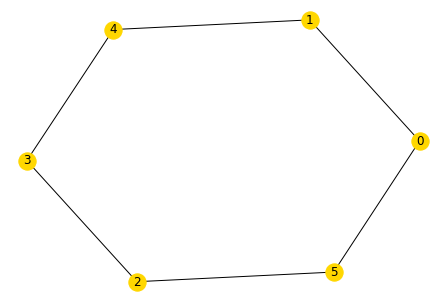

In [5]:
test_graphs = glob.glob('benchmark_graphs/N6_d2_graphs/*')
print(len(test_graphs))
test_graph = test_graphs[1]
G = graph_from_file(test_graph)
print(nx.is_connected(G))
nx.draw_spring(G, with_labels=True, node_color='gold')

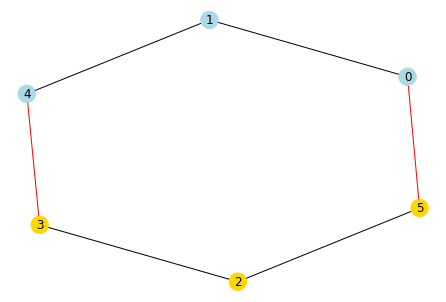

In [6]:
kl_bisection = kernighan_lin_bisection(G)
view_partition(kl_bisection, G)

In [7]:
nq = len(G.nodes())
P = 1
mixer_order = list(range(nq))
np.random.shuffle(mixer_order)

init_state = '0'*nq

(G_A, G_B), cutedges = get_subgraphs(G, kl_bisection)
print('G_A nodes:', G_A.nodes)
print('G_B nodes:', G_B.nodes)
print('cutedges:', cutedges)
cut_nodes = []
for edge in cutedges:
    cut_nodes.extend(edge)
cutnodes = list(set(cut_nodes))
print('cutnodes:', cut_nodes)
uncut_nodes = list(set(G.nodes).difference(set(cut_nodes)))
print('uncut nodes:', uncut_nodes)

Q_A_uc = [node for node in G_A.nodes if node in uncut_nodes]
Q_A_c = [node for node in G_A.nodes if node in cut_nodes]

Q_B_uc = [node for node in G_B.nodes if node in uncut_nodes]
Q_B_c = [node for node in G_B.nodes if node in cut_nodes]

print('Q_A_uc: {}, Q_A_c: {}'.format(Q_A_uc, Q_A_c))
print('Q_B_uc: {}, Q_B_c: {}'.format(Q_B_uc, Q_B_c))

hot_nodes = []
cut_limit = 2
cut_count = 0
starter_idx = 1
starter_graph = (G_A, G_B)[starter_idx]
starter_cut_nodes = (Q_A_c, Q_B_c)[starter_idx]
np.random.shuffle(starter_cut_nodes)
starter_cut_nodes = sorted(starter_cut_nodes,
                           key=lambda n: len((list(starter_graph.neighbors(n)))),
                           reverse=True)
print(starter_cut_nodes)
for node in starter_cut_nodes:
    t = len([e for e in cutedges if node in e])
    print('node, t:', node, t)
    if t + cut_count <= cut_limit and list(reversed(init_state))[node] != '1':
        hot_nodes.append(node)
        cut_count += t
print('hot_nodes:', hot_nodes)

uncut_nonzero = len([n for n in uncut_nodes if init_state[n] != '1'])
num_params = P * (uncut_nonzero + 1) + len(hot_nodes)

#num_nonzero = nq - hamming_weight(init_state)
#print('lim1:', P * (nq + 1))
#print('lim2:', (P+1) * (num_nonzero + 1))
#num_params = min(P * (nq + 1), (P+1) * (num_nonzero + 1))
#num_params = P * ()
params = list(range(1, num_params + 1))
print('params:', params)

G_A nodes: [2, 3, 5]
G_B nodes: [0, 1, 4]
cutedges: [(0, 5), (4, 3)]
cutnodes: [0, 5, 4, 3]
uncut nodes: [1, 2]
Q_A_uc: [2], Q_A_c: [3, 5]
Q_B_uc: [1], Q_B_c: [0, 4]
[4, 0]
node, t: 4 1
node, t: 0 1
hot_nodes: [4, 0]
params: [1, 2, 3, 4, 5]


In [8]:
mixer_order = list(range(nq))
circ = gen_cut_dqva(G, kl_bisection, uncut_nodes, P=P, params=params,
                    init_state=init_state, barriers=2, decompose_toffoli=1,
                    mixer_order=mixer_order, hot_nodes=hot_nodes, verbose=1)
circ.draw(fold=-1)

Current partition: ({2, 3, 5}, {0, 1, 4})
subgraphs: [[2, 3, 5], [0, 1, 4]]
cutedges: [(0, 5), (4, 3)]
hot nodes: [4, 0]
alpha_0: [1, 2, 3, 4]
gamma_0: 5
Mixer order: [0, 1, 2, 3, 4, 5]
init_state: 000000, alpha: [1, 2, 3, 4], pad_alpha: [1, 2, 3, None, 4, None]
Subgraph dict: {2: 0, 3: 0, 5: 0, 0: 1, 1: 1, 4: 1}
qubit: 0 num_qubits = 8 neighbors: [1, 5]
qubit: 1 num_qubits = 8 neighbors: [0, 4]
qubit: 2 num_qubits = 8 neighbors: [3, 5]
qubit: 4 num_qubits = 8 neighbors: [1, 3]


░                ┌───────┐                ░ ┌───┐     ┌───┐  ┌───┐            ┌───┐ ░                                         ░                                    ░ ┌────────┐
  q_0: ─░────────────────┤ RX(2) ├────────────────░─┤ X ├──■──┤ X ├──┤ X ├─────────■──┤ X ├─░─────────────────────────────────────────░────────────────────────────────────░─┤ RZ(10) ├
        ░ ┌───┐     ┌───┐└───┬───┘┌───┐     ┌───┐ ░ └───┘  │  └───┘┌─┴───┴─┐       │  └───┘ ░                                         ░ ┌───┐       ┌───┐  ┌───┐     ┌───┐ ░ ├────────┤
  q_1: ─░─┤ X ├──■──┤ X ├────┼────┤ X ├──■──┤ X ├─░────────┼───────┤ RX(4) ├───────┼────────░─────────────────────────────────────────░─┤ X ├──■────┤ X ├──┤ X ├──■──┤ X ├─░─┤ RZ(10) ├
        ░ └───┘  │  └───┘    │    └───┘  │  └───┘ ░        │       └───┬───┘       │        ░                ┌───────┐                ░ └───┘  │    └───┘  └───┘  │  └───┘ ░ ├────────┤
  q_2: ─░────────┼───────────┼───────────┼────────░────────┼───────────┼───────────┼────────░────────────────┤ RX(6) ├────────────────░────────┼──────────────────┼────────░─┤ RZ(10) ├
        ░        │           │           │        ░        │           │           │        ░ ┌───┐     ┌───┐└───┬───┘┌───┐     ┌───┐ ░ ┌───┐  │    ┌───┐  ┌───┐  │  ┌───┐ ░ ├────────┤
  q_3: ─░────────┼───────────┼───────────┼────────░────────┼───────────┼───────────┼────────░─┤ X ├──■──┤ X ├────┼────┤ X ├──■──┤ X ├─░─┤ X ├──■────┤ X ├──┤ X ├──■──┤ X ├─░─┤ RZ(10) ├
        ░        │           │           │        ░ ┌───┐  │  ┌───┐    │    ┌───┐  │  ┌───┐ ░ └───┘  │  └───┘    │    └───┘  │  └───┘ ░ └───┘  │  ┌─┴───┴─┐└───┘  │  └───┘ ░ ├────────┤
  q_4: ─░────────┼───────────┼───────────┼────────░─┤ X ├──■──┤ X ├────┼────┤ X ├──■──┤ X ├─░────────┼───────────┼───────────┼────────░────────┼──┤ RX(8) ├───────┼────────░─┤ RZ(10) ├
        ░ ┌───┐  │  ┌───┐    │    ┌───┐  │  ┌───┐ ░ └───┘  │  └───┘    │    └───┘  │  └───┘ ░ ┌───┐  │  ┌───┐    │    ┌───┐  │  ┌───┐ ░        │  └───┬───┘       │        ░ ├────────┤
  q_5: ─░─┤ X ├──■──┤ X ├────┼────┤ X ├──■──┤ X ├─░────────┼───────────┼───────────┼────────░─┤ X ├──■──┤ X ├────┼────┤ X ├──■──┤ X ├─░────────┼──────┼───────────┼────────░─┤ RZ(10) ├
        ░ └───┘  │  └───┘    │    └───┘  │  └───┘ ░        │           │           │        ░ └───┘┌─┴─┐└───┘    │    └───┘┌─┴─┐└───┘ ░        │      │           │        ░ └────────┘
anc_0: ─░────────┼───────────┼───────────┼────────░────────┼───────────┼───────────┼────────░──────┤ X ├─────────■─────────┤ X ├──────░────────┼──────┼───────────┼────────░───────────
        ░      ┌─┴─┐         │         ┌─┴─┐      ░      ┌─┴─┐         │         ┌─┴─┐      ░      └───┘                   └───┘      ░      ┌─┴─┐    │         ┌─┴─┐      ░           
anc_1: ─░──────┤ X ├─────────■─────────┤ X ├──────░──────┤ X ├─────────■─────────┤ X ├──────░─────────────────────────────────────────░──────┤ X ├────■─────────┤ X ├──────░───────────
        ░      └───┘                   └───┘      ░      └───┘                   └───┘      ░                                         ░      └───┘              └───┘      ░

In [9]:
# Programmatically locate the cut locations
#cuts = [(circ.qubits[2], 6)]
print('hot nodes:', hot_nodes)
applied_mixers = [n for n in uncut_nodes + hot_nodes if list(reversed(init_state))[n] != '1']
print('applied mixers:', applied_mixers)

cuts = []
for edge in cutedges:
    print('cut edge:', edge)
    if edge[0] in hot_nodes:
        cut_qubit = edge[1]
        loc_qubit = edge[0]
    elif edge[1] in hot_nodes:
        cut_qubit = edge[0]
        loc_qubit = edge[1]
    else:
        continue
    assert cut_qubit not in hot_nodes
    print('cut_qubit:', cut_qubit, ', loc_qubit:', loc_qubit)
    
    num_mixers_before = 0
    num_mixers_after  = 0
    passed = False # a boolean to keep track when we've passed the loc_qubit
    for mixer in mixer_order:
        # step through each partial mixer in order
        if mixer not in applied_mixers:
            # if this partial mixer is identity, skip
            continue
        
        if mixer == loc_qubit:
            # this is the partial mixer where we'll apply the cut(s)
            passed = True
        
        else:
            # check if this mixer has a control on the cut qubit
            if cut_qubit in list(G.neighbors(mixer)):
                if passed:
                    # if we've passed the loc_qubit
                    num_mixers_after += 1
                else:
                    # if we haven't passed the loc_qubit
                    num_mixers_before += 1
    
    print('num_mixers_before:', num_mixers_before)
    print('num_mixers_after:', num_mixers_after)
    
    if num_mixers_before > 0:
        cuts.append((circ.qubits[cut_qubit], num_mixers_before * 6))
    if num_mixers_after > 0:
        cuts.append((circ.qubits[cut_qubit], num_mixers_after * 6))
    
print('cuts:')
#cuts = [(Qubit(QuantumRegister(12, 'q'), 9), 6), (Qubit(QuantumRegister(12, 'q'), 1), 12)]
#cuts = cuts[:-1]
print(cuts)

hot nodes: [4, 0]
applied mixers: [1, 2, 4, 0]
cut edge: (0, 5)
cut_qubit: 5 , loc_qubit: 0
num_mixers_before: 0
num_mixers_after: 1
cut edge: (4, 3)
cut_qubit: 3 , loc_qubit: 4
num_mixers_before: 1
num_mixers_after: 0
cuts:
[(Qubit(QuantumRegister(6, 'q'), 5), 6), (Qubit(QuantumRegister(6, 'q'), 3), 6)]


In [10]:
frag_num = 2
fragments, wire_path_map = qcc.cut_circuit(circ, cuts)
#fragment_cuts = qmm.fragment_cuts(frag_num, wire_path_map)
for i, frag in enumerate(fragments):
    print('Fragment', i)
    print(frag.draw(fold=120))

print()
for key, val in wire_path_map.items():
    print(key, '-->', val)

Fragment 0
     ┌───┐                                       ┌───┐  ┌───┐            ┌───┐               ┌───────┐┌────────┐     »
q_0: ┤ X ├────────────────────────────────────■──┤ X ├──┤ X ├─────────■──┤ X ├───────────────┤ RX(8) ├┤ RZ(10) ├─────»
     ├───┤     ┌───┐  ┌───┐            ┌───┐  │  └───┘┌─┴───┴─┐┌───┐  │  └───┘┌───┐  ┌───┐   └───┬───┘└────────┘┌───┐»
q_1: ┤ X ├──■──┤ X ├──┤ X ├─────────■──┤ X ├──┼───────┤ RX(4) ├┤ X ├──┼────■──┤ X ├──┤ X ├───────┼────────■─────┤ X ├»
     └───┘  │  └───┘┌─┴───┴─┐┌───┐  │  └───┘  │  ┌───┐└───┬───┘├───┤  │    │  ├───┤┌─┴───┴──┐    │        │     └───┘»
q_2: ───────┼───────┤ RX(2) ├┤ X ├──┼─────────■──┤ X ├────┼────┤ X ├──■────┼──┤ X ├┤ RZ(10) ├────┼────────┼──────────»
     ┌───┐  │       └───┬───┘└───┘  │         │  └───┘    │    └───┘  │    │  ├───┤└─┬───┬──┘    │        │     ┌───┐»
q_3: ┤ X ├──┼───────────┼───────────┼─────────┼───────────┼───────────┼────■──┤ X ├──┤ X ├───────┼────────■─────┤ X ├»
     ├───┤  │  ┌───┐    │    ┌───┐  │

In [11]:
frag_data = qmm.collect_fragment_data(fragments, wire_path_map, shots=500000, tomography_backend='qasm_simulator')
direct_models = qmm.direct_fragment_model(frag_data)
likely_models = qmm.maximum_likelihood_model(direct_models)

likely_recombined_dist = qmm.recombine_fragment_models(likely_models, wire_path_map)
print({key: val for key, val in likely_recombined_dist.items() if val > 0.001})

/Users/teague/anaconda3/envs/cutEnv/lib/python3.7/site-packages/qiskit/ignis/verification/tomography/basis/sicbasis.py:48: DeprecationWarning: The QuantumCircuit.u3 method is deprecated as of 0.16.0. It will be removed no earlier than 3 months after the release date. You should use QuantumCircuit.u instead, which acts identically. Alternatively, you can decompose u3 in terms of QuantumCircuit.p and QuantumCircuit.sx: u3(ϴ,φ,λ) = p(φ+π) sx p(ϴ+π) sx p(λ) (2 pulses on hardware).
  circ.u3(theta, np.pi, 0.0, qubit)


{'00000000': 0.021050046405561254, '00010000': 0.028272875603825517, '00000010': 0.23644616439067845, '00000110': 0.004725353993648938, '00000001': 0.296480100544314, '00000101': 0.0059251063446873736, '00010001': 0.3973799546124058, '00010101': 0.007941395311757495}


In [12]:
circ.measure_all()
shots = 200000
result = execute(circ, backend=Aer.get_backend('qasm_simulator'), shots=shots).result()
counts = result.get_counts(circ)
actual_dist = {sample: counts[sample] / shots for sample in counts.keys()}
print(actual_dist)

{'00000000': 0.02109, '00000001': 0.29659, '00010000': 0.02852, '00010001': 0.39856, '00010100': 0.00056, '00010101': 0.00792, '00000010': 0.235745, '00000100': 0.00033, '00000101': 0.00578, '00000110': 0.004905}


In [13]:
fidelity(likely_recombined_dist, actual_dist)

0.9991968386338639